<a href="https://colab.research.google.com/github/BrendenLatham/Data_Viz/blob/main/Masters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


I am going to be using the above data to recreate a graph comparing the current location of each country on it's pandemic curve relative to it's peak

First I want to see all the columns in this dataset

In [ ]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

This data is supposed to have been updated daily so I want to see the max new_cases for each country

In [ ]:
maxes = df.groupby('location').new_cases.agg('max')
maxes.head()

location
Afghanistan     3243.0
Africa         60523.0
Albania         4789.0
Algeria         2521.0
Andorra         2313.0
Name: new_cases, dtype: float64

Now I want to actually see the latest report for each country

In [ ]:
LatestReport = df.groupby('location').date.max()
LatestReport.head()

location
Afghanistan    2022-04-27
Africa         2022-04-27
Albania        2022-04-27
Algeria        2022-04-27
Andorra        2022-04-27
Name: date, dtype: object

If you look at all values it looks like some countries haven't been updated in a bit

This might cause problems but we shall see later on

I want to get a list of the countries that dont have yestardays data in

In [ ]:
non_current = (x for x in LatestReport if x != max(LatestReport))
non_current_list = []
for i in non_current:
  non_current_list.append(LatestReport[LatestReport == i].index[0])
non_current_list

['Guam',
 'Guernsey',
 'Jersey',
 'Nauru',
 'Niue',
 'Northern Cyprus',
 'Northern Mariana Islands',
 'Pitcairn',
 'Puerto Rico',
 'Sint Maarten (Dutch part)',
 'Tokelau',
 'Turkmenistan',
 'Tuvalu',
 'Puerto Rico',
 'Guam']

For these countries I will just use the most recent data

I will now create one dataframe that we will use for the graph

In [ ]:
locations = df.location.unique()
locations

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [ ]:
data1 = df.groupby('location', as_index = False).date.max()
data2 = df.groupby('location', as_index = False).new_cases.max().new_cases
data = pd.concat([data1,data2],axis = 1)
data.columns = ['location','date','max_new_cases']

In [ ]:
data_to_join = df[['location','date','new_cases']]
data

,location,date,max_new_cases
0,Afghanistan,2022-04-27,3243.0
1,Africa,2022-04-27,60523.0
2,Albania,2022-04-27,4789.0
3,Algeria,2022-04-27,2521.0
4,Andorra,2022-04-27,2313.0
...,...,...,...
238,Western Sahara,2022-04-20,NaN
239,World,2022-04-27,4089128.0
240,Yemen,2022-04-27,287.0
241,Zambia,2022-04-27,5555.0


In [ ]:
data = pd.merge(data, data_to_join, how = 'left', left_on = ['location','date'], right_on = ['location','date'])
data

,location,date,max_new_cases,new_cases
0,Afghanistan,2022-04-27,3243.0,40.0
1,Africa,2022-04-27,60523.0,6732.0
2,Albania,2022-04-27,4789.0,67.0
3,Algeria,2022-04-27,2521.0,1.0
4,Andorra,2022-04-27,2313.0,0.0
...,...,...,...,...
238,Western Sahara,2022-04-20,NaN,NaN
239,World,2022-04-27,4089128.0,844207.0
240,Yemen,2022-04-27,287.0,0.0
241,Zambia,2022-04-27,5555.0,NaN


In [ ]:
data['percent_of_max'] = data.new_cases/data.max_new_cases
data.head()

,location,date,max_new_cases,new_cases,percent_of_max
0,Afghanistan,2022-04-27,3243.0,40.0,0.012334
1,Africa,2022-04-27,60523.0,6732.0,0.111230
2,Albania,2022-04-27,4789.0,67.0,0.013990
3,Algeria,2022-04-27,2521.0,1.0,0.000397
4,Andorra,2022-04-27,2313.0,0.0,0.000000
...,...,...,...,...,...
238,Western Sahara,2022-04-20,NaN,NaN,NaN
239,World,2022-04-27,4089128.0,844207.0,0.206452
240,Yemen,2022-04-27,287.0,0.0,0.000000
241,Zambia,2022-04-27,5555.0,NaN,NaN


Now lets drop any null values

In [ ]:
data = data.dropna()

,location,date,max_new_cases,new_cases,percent_of_max
0,Afghanistan,2022-04-27,3243.0,40.0,0.012334
1,Africa,2022-04-27,60523.0,6732.0,0.111230
2,Albania,2022-04-27,4789.0,67.0,0.013990
3,Algeria,2022-04-27,2521.0,1.0,0.000397
4,Andorra,2022-04-27,2313.0,0.0,0.000000
...,...,...,...,...,...
236,Vietnam,2022-04-27,454212.0,11313.0,0.024907
237,Wallis and Futuna,2022-04-27,47.0,0.0,0.000000
239,World,2022-04-27,4089128.0,844207.0,0.206452
240,Yemen,2022-04-27,287.0,0.0,0.000000


Now for the visualization

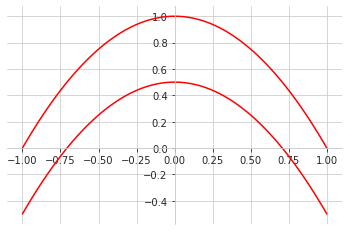

In [ ]:
x = np.linspace(-1,1,100)


y1 = -x**2+1
y2 = -x**2+.5

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.plot(x,y1, 'r')
plt.plot(x,y2, 'r')

plt.show()

<function matplotlib.pyplot.show>

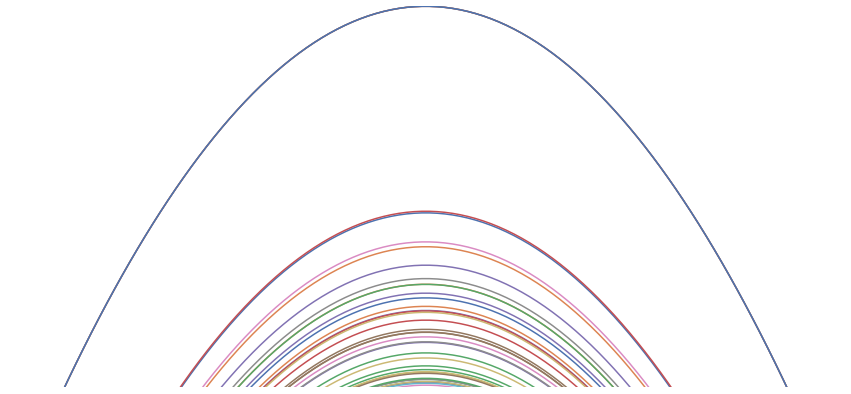

In [ ]:
x = np.linspace(-1,1,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylim(0.1)
plt.axis('off')
sns.set(rc={'figure.figsize':(15,7)})
ax.set_facecolor((1.0, 0.47, 0.42))

for i in data['percent_of_max']:
  y = -x**2+i
  plt.plot(x,y)
y2 = -x**2+1
plt.plot(x,y2)
plt.show